**By Edwin Tembo, Masters Candidate, Harvard Extension School , ALM, Data Science, December-2025.**

This notebook is one of many used as part of our Data Science Capstone Project for the Harvard Extension School's Data Science Masters Degree Program (ALM).

We explore how an LLM-AS-Judge Approach can be used to evaluate the output of  another LLM.

AI Usage Notice :

AI was used to generate some starter code, for code review and formatting (PEP-8).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy  as np
from   pathlib  import Path
import fsspec
import os
import time
import sys
import traceback

In [4]:
!pip install -q google-genai==1.55.0 google-cloud-storage==3.6.0 google-cloud-bigquery==3.38.0

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [10]:
from google import genai
from google.cloud import bigquery, storage
from google.genai.types import CreateBatchJobConfig
from   datetime import datetime


In [ ]:


from google.colab import userdata
os.environ['GOOGLE_CLOUD_PROJECT'] = userdata.get('gcp_project_id')

In [ ]:
import os

PROJECT_ID = "[your-project-id]"  # @param {type: "string", placeholder: "[your-project-id]", isTemplate: true}
if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

In [ ]:
client = genai.Client(vertexai=True, project=PROJECT_ID, location=LOCATION)

In [ ]:
MODEL_ID = "gemini-2.5-flash"  # @param {type:"string", isTemplate: true}

In [ ]:
INPUT_DATA =userdata.get(f'llm_as_judge_input_bucket')

In [ ]:
!gcloud auth login
!gcloud auth application-default login

In [ ]:
! gcloud auth application-default set-quota-project {PROJECT_ID}

In [ ]:
! gsutil mb -l us-central1 -p {PROJECT_ID} {INPUT_DATA}

In [ ]:

storage_client = storage.Client()
inputs_bucket = storage_client.bucket(INPUT_DATA.replace( 'gs://', ''))
blobs_all = list(inputs_bucket.list_blobs())
inputs_bucket = storage_client.bucket(INPUT_DATA.replace( 'gs://', ''))

In [ ]:
OUTPUT_BUCKET = userdata.get(f'llm_as_judge_out_bucket')
!gsutil mb -l us-central1 -p {PROJECT_ID} {OUTPUT_BUCKET}

Creating gs://gemini-llm-judges-out/...
ServiceException: 409 A Cloud Storage bucket named 'gemini-llm-judges-out' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [ ]:

"""
Generate JSONL files for Gemini Batch Inference (LLM as Judge).
This script takes a dataframe of prompts and responses, constructs the judge prompts,
and saves them to a JSONL file suitable for batch processing.
"""

import pandas as pd
import json
import argparse
from typing import List, Dict, Any
import os

def create_judge_prompt(prompt: str, response: str, criteria: List[str]) -> str:
    """
    Create the evaluation prompt with a robust scoring rubric.
    """
    criteria_str = "\n".join([f"- {c}" for c in criteria])

    return f"""You are an expert evaluator of AI responses. Your task is to evaluate the following response objectively and fairly based on the provided criteria.

**Evaluation Rubric (0-10 Scale):**
- **0-2 (Critical Failure):** The response is completely incorrect, irrelevant, incoherent, or dangerous. Fails to follow instructions.
- **3-4 (Poor):** Major issues with accuracy, logic, or helpfulness. Misses key parts of the prompt.
- **5-6 (Acceptable):** Technically correct but vague, unstructured, or missing nuance. "Okay" but not good.
- **7-8 (Good):** Accurate, clear, and helpful. Follows instructions well with only minor flaws.
- **9-10 (Excellent):** Perfect, insightful, comprehensive, and well-structured. Exceeds expectations.

**Evaluation Criteria:**
{criteria_str}

**User Prompt:**
{prompt}

**AI Response:**
{response}

Provide your evaluation in the following JSON format:
{{
    "overall_score": <float 0-10>,
    "criteria_scores": {{
        {', '.join([f'"{c.split(" ")[0].lower()}": <float 0-10>' for c in criteria])}
    }},
    "strengths": ["strength1", "strength2", ...],
    "weaknesses": ["weakness1", "weakness2", ...],
    "reasoning": "Detailed explanation justifying the scores based on the rubric",
    "recommended_improvements": ["improvement1", "improvement2", ...]
}}

Ensure your reasoning is consistent with the scores given. Return ONLY the JSON, no additional text."""

def generate_batch_jsonl(
    df: pd.DataFrame,
    output_file: str,
    prompt_col: str = 'prompt',
    response_col: str = 'response',
    id_col: str = None,
    criteria: List[str] = None,
    model_name: str = "models/gemini-1.5-flash",
    temperature: float = 0.1
):
    """
    Generate JSONL file for Gemini batch inference.

    Args:
        df: Input DataFrame
        output_file: Output JSONL file path
        prompt_col: Column name for prompts
        response_col: Column name for responses
        id_col: Column name for unique IDs (optional)
        criteria: List of evaluation criteria
        model_name: Gemini model name
        temperature: Temperature for generation
    """
    if criteria is None:
        # Robust default criteria
        criteria = [
            "Coherence (Logical flow, clarity, and structure)",
            "Consistency (Internal logic and reasoning matches conclusions)",
            "Helpfulness (Directly addresses user intent and provides value)",
            "Completeness (Covers all aspects of the prompt)"
        ]

    print(f"Generating batch file for {len(df)} records...")
    print(f"Output: {output_file}")
    print(f"Model: {model_name}")

    with open(output_file, 'w', encoding='utf-8') as f:
        for idx, row in df.iterrows():
            # Get ID
            custom_id = str(row[id_col]) if id_col and id_col in df.columns else str(idx)

            # Construct prompt
            user_prompt = row.get(prompt_col, "")
            ai_response = row.get(response_col, "")

            judge_prompt = create_judge_prompt(user_prompt, ai_response, criteria)

            # Construct request object
            # This format matches the Google Gen AI Batch API requirements
            request = {
                "custom_id": custom_id,
                "method": "POST",
                "url": f"/v1beta/{model_name}:generateContent",
                "body": {
                    "contents": [
                        {
                            "parts": [
                                {"text": judge_prompt},
                            ],
                            "role":"user"

                        }
                    ],
                    "generation_config": {
                                          "temperature": temperature,
                                          "response_mime_type": "application/json"
                                        }

                }
            }

            f.write(json.dumps(request) + '\n')

    print("Done.")

if __name__ == "__main__":
    # Test configuration
    OUTPUT_FILE = "gemini_batch_requests.jsonl"
    MODEL_NAME = "models/gemini-2.5-flash"

    # Create sample data for testing
    print("Creating sample data...")
    data = {
        "id": ["test_001", "test_002", "test_003"],
        "prompt": [
            "What is the capital of France?",
            "Explain the theory of relativity in one sentence.",
            "Write a python function to add two numbers."
        ],
        "response": [
            "The capital of France is Paris.",
            "Relativity states that time and space are relative to the observer's motion and gravity.",
            "def add(a, b): return a - b"  # Intentional error for testing
        ]
    }
    df = pd.DataFrame(data)

    # Define robust criteria for the test
    test_criteria = [
        "Accuracy (Factuality and correctness)",
        "Coherence (Clarity and logical flow)",
        "Helpfulness (Utility to the user)",
        "Reasoning (Quality of explanation)"
    ]

    # Generate the batch file
    generate_batch_jsonl(
        df,
        OUTPUT_FILE,
        prompt_col='prompt',
        response_col='response',
        id_col='id',
        criteria=test_criteria,
        model_name=MODEL_NAME
    )

    print(f"\nTest complete. Check {OUTPUT_FILE} for the generated JSONL content.")


Creating sample data...
Generating batch file for 3 records...
Output: gemini_batch_requests.jsonl
Model: models/gemini-1.5-flash
Done.

Test complete. Check gemini_batch_requests.jsonl for the generated JSONL content.


In [ ]:
import pandas as pd
import os
import sys
import json
from datetime  import datetime
from typing    import Dict, Any, List
from functools import lru_cache

# Import generate_batch_jsonl from the existing script
# Assuming the script is in the same directory

# Configuration
# Using paths from the notebook as requested

NOTEBOOK_BASE_PATH =  '{{YOUR_BASE_PATH}}'
LLM_AS_JUDGE_PATH =  '{{YOUR_LLM_AS_JUDGE_PATH}}'

input_data_path    = f'{LLM_AS_JUDGE_PATH}/gemini_2.5_flash/input_data'

os.makedirs(input_data_path, exist_ok=True)

@lru_cache(maxsize=None)
def read_text(file_path):
    """Reads the content of a text file with caching."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return f.read()
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return ""
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return ""

list_of_fed_chairs = """
Alan Greenspan: Served from 1987 to 2006, so he was chair for the first six years of the 21st century.
Ben Bernanke: Served from 2006 to 2014.
Janet Yellen: Served from 2014 to 2018.
Jerome Powell: Took office in 2018 and is the current Federal Reserve Chair.
"""

# Treasury Knowledge Base Logic
_TREASURY_KNOWLEDGE_BASE = read_text(f'{NOTEBOOK_BASE_PATH}/us_treasury_market_playbook_updated.txt')
_TREASURY_KNOWLEDGE_BASE = _TREASURY_KNOWLEDGE_BASE + ' ' + list_of_fed_chairs

def get_default_treasury_knowledge() -> str:
    """Fallback knowledge base if file is not available"""
    return """
    US TREASURY MARKET KNOWLEDGE BASE:

    Key Factors Affecting Treasury Prices:
    1. Federal Reserve Policy: Interest rate decisions, QE programs, forward guidance
    2. Economic Indicators: Inflation data (CPI, PCE), employment reports, GDP growth
    3. Market Sentiment: Risk-on vs risk-off sentiment, flight to quality
    4. Geopolitical Events: Wars, trade tensions, political uncertainty
    5. Supply and Demand: Treasury auctions, foreign central bank purchases

    Fed Chairs and Their Impact:
    - Alan Greenspan (1987-2006): Known for market-friendly policies
    - Ben Bernanke (2006-2014): Implemented QE programs during financial crisis
    - Janet Yellen (2014-2018): Gradual rate normalization
    - Jerome Powell (2018-present): Flexible inflation targeting, COVID response

    Market Dynamics:
    - Positive news about economic growth typically pressures Treasury prices lower
    - Negative economic news or uncertainty drives flight to quality, pushing prices higher
    - Hawkish Fed commentary pressures prices lower; dovish commentary supports prices
    """

def load_treasury_knowledge() -> str:
    """Load the Treasury knowledge base from file"""
    global _TREASURY_KNOWLEDGE_BASE

    if _TREASURY_KNOWLEDGE_BASE is not None:
        return _TREASURY_KNOWLEDGE_BASE

    # Try to find the file in multiple locations
    possible_paths = [
        os.path.join(NOTEBOOK_BASE_PATH, 'us_treasury_market_playbook_updated.txt'),
        os.path.join(os.getcwd(), 'us_treasury_market_playbook_updated.txt'),
        'us_treasury_market_playbook_updated.txt'
    ]

    for kb_path in possible_paths:
        # Check if path exists (handling potential windows/linux path issues if NOTEBOOK_BASE_PATH is mixed)
        if os.path.exists(kb_path):
            try:
                with open(kb_path, 'r', encoding='utf-8') as f:
                    print(f"Loading Treasury Knowledge Base from: {kb_path}")
                    _TREASURY_KNOWLEDGE_BASE = f.read()
                    return _TREASURY_KNOWLEDGE_BASE
            except Exception as e:
                print(f"Error reading knowledge base from {kb_path}: {e}")

    # Default to the hardcoded string
    print("Treasury Knowledge Base file not found. Using default knowledge base.")
    _TREASURY_KNOWLEDGE_BASE = get_default_treasury_knowledge()
    return _TREASURY_KNOWLEDGE_BASE

def treasury_knowledge_search(query: str) -> str:
    """Search Treasury knowledge base for relevant information"""
    knowledge_base = load_treasury_knowledge()
    query_lower = query.lower()

    # Simple keyword-based retrieval
    relevant_sections = []
    knowledge_sections = knowledge_base.split('\n\n')

    for section in knowledge_sections:
        if len(section.strip()) > 20:  # Skip very short sections
            if any(keyword in section.lower() for keyword in query_lower.split()):
                relevant_sections.append(section)

    if relevant_sections:
        return "\n\n".join(relevant_sections[:3])  # Return top 3 relevant sections
    else:
        return f"General Treasury market information: {knowledge_base[:1000]}..."

def recreate_prompt(article_data: Dict[str, Any]) -> str:
    """
    Recreate the prompt used in analyze_article_simple.
    """
    # Get relevant Treasury context
    query = f"Fed policy impact Treasury prices {article_data.get('speaker', '')} {article_data['title']}"
    treasury_context = treasury_knowledge_search(query)

    # Create speaker section
    # Note: 'speeches' is not in ('testimony', 'speech'), so it defaults to Author
    speaker_section = (f"Speaker: {article_data['speaker']}"
                      if article_data['doc_type'] in ('testimony', 'speech')
                      else f"Author: {article_data['author']}")

    # Template string from the notebook
    template = """
You are a financial sentiment analysis expert specializing in US Treasury markets.

Current date: {date}

Analyze the following document for its impact on US Treasury bond prices:

Document Type: {doc_type}
Title: {title}
Date: {pub_date}
{speaker_section}

Content: {text}

Treasury Market Context:
{treasury_context}

IMPORTANT: Provide your analysis in EXACTLY this JSON format:
{{
    "sentiment": "positive|negative|neutral",
    "score": 0.0-1.0,
    "explanation": "Brief single sentence explanation"
}}

SENTIMENT DEFINITIONS:
- positive: Likely to INCREASE Treasury prices (DECREASE yields) - bullish for bonds
- negative: Likely to DECREASE Treasury prices (INCREASE yields) - bearish for bonds
- neutral: No significant impact expected

SCORE: Confidence and magnitude (0.0 = no impact, 1.0 = maximum impact)
"""

    # Format the prompt
    formatted_prompt = template.format(
        date=datetime.now().strftime("%B %d, %Y"),
        doc_type=article_data['doc_type'].capitalize(),
        title=article_data['title'],
        pub_date=article_data['pub_date'],
        speaker_section=speaker_section,
        text=article_data['text'],
        treasury_context=treasury_context[:1000]
    )

    return formatted_prompt




def main(temperature):
    # Define the document types and their corresponding files
    tasks = [
        {
            'doc_type': 'speeches',
            'input_path': f'{NOTEBOOK_BASE_PATH}/News/speeches',
            'result_path': f'{NOTEBOOK_BASE_PATH}/results/speeches_full'
        },
        {
            'doc_type': 'testimony',
            'input_path': f'{NOTEBOOK_BASE_PATH}/News/testimony',
            'result_path': f'{NOTEBOOK_BASE_PATH}/results/testimony_full'
        },
        {
            'doc_type': 'press_releases',
            'input_path': f'{NOTEBOOK_BASE_PATH}/News/press_releases',
            'result_path': f'{NOTEBOOK_BASE_PATH}/results/press_releases_full_fomc'
        }
    ]

    for task in tasks:
        doc_type = task['doc_type']
        print(f"Processing {doc_type}...")

        try:
            # Load Data
            print(f"Loading input data from {task['input_path']}...")
            if not os.path.exists(task['input_path']) and not task['input_path'].startswith('/content'):
                 # Try to find it in current directory if not absolute path
                 pass

            try:
                df_input = pd.read_parquet(task['input_path'])
            except Exception as e:
                print(f"Failed to load input data: {e}")
                continue

            print(f"Loading results data from {task['result_path']}...")
            try:
                df_results = pd.read_parquet(task['result_path'])
            except Exception as e:
                print(f"Failed to load results data: {e}")
                continue

            # Ensure columns exist and handle missing values
            if 'text' not in df_input.columns:
                print(f"Warning: 'text' column missing in input for {doc_type}")
                continue

            # Fill missing speaker/author in input
            if 'speaker' not in df_input.columns: df_input['speaker'] = ''
            if 'author'  not in df_input.columns: df_input['author'] = ''
            df_input['speaker'] = df_input['speaker'].fillna('')
            df_input['author']  = df_input['author'].fillna('')

            # --- Filtering Logic ---
            initial_count = len(df_input)

            if doc_type == 'press_releases':
                # Filter for FOMC press releases
                # Title contains 'fomc' (ignoring dots) or 'federal open market'
                # AND does not contain 'minutes'

                # Normalize title for checking: lowercase and remove dots
                clean_title = df_input['title'].str.lower().str.replace('.', '', regex=False)

                mask = (
                    (clean_title.str.contains('fomc', regex=False)) |
                    (df_input['title'].str.lower().str.contains('federal open market', regex=False))
                ) & (~df_input['title'].str.lower().str.contains('minutes', regex=False))

                df_input = df_input[mask]
                print(f"Filtered press_releases from {initial_count} to {len(df_input)} records (FOMC only, no minutes).")

            else:
                # Filter by Speaker for speeches and testimony
                # Speakers: Greenspan, Bernanke, Yellen, Powell
                if 'speaker' in df_input.columns:
                    mask = df_input['speaker'].str.contains(r'Greenspan|Bernanke|Yellen|Powell', regex=True, case=False, na=False)
                    df_input = df_input[mask]
                    print(f"Filtered {doc_type} from {initial_count} to {len(df_input)} records (Fed Chairs only).")

            if len(df_input) == 0:
                print(f"No records left after filtering for {doc_type}. Skipping.")
                continue

            # Merge on title
            # We use inner join to ensure we have both text and the result
            merged_df = pd.merge(df_results, df_input[['date','title', 'text', 'speaker', 'author']], on=['title', 'date'], how='inner')

            # Remove duplicates if any
            ##merged_df = merged_df.drop_duplicates(subset=['title', 'date'])


            assert len(df_results) == len(merged_df) , f'Length mismatch {doc_type}'
            ##print(f"Matched {len(merged_df)} records.")

            if len(merged_df) == 0:
                print("No records matched. Skipping.")
                continue

            # Recreate Prompts
            prompts = []
            responses = []

            for idx, row in merged_df.iterrows():
                article_data = {
                    'doc_type': doc_type,
                    'title': row['title'],
                    'pub_date': row['date'] if 'date' in row else '',
                    'speaker': row['speaker'],
                    'author': row['author'],
                    'text': row['text']
                }

                prompt = recreate_prompt(article_data)
                prompts.append(prompt)

                # The response is the raw output from the agent
                responses.append(row['raw_agent_output'])

            # Create DataFrame for Judge
            judge_df = pd.DataFrame({
                'prompt': prompts,
                'response': responses,
                'original_title': merged_df['title'],
                'speaker': merged_df['speaker'],
                'date': merged_df['date'] if 'date' in merged_df.columns else (merged_df['pub_date'] if 'pub_date' in merged_df.columns else '')
            })

            # Save to Parquet
            output_parquet = f'{input_data_path}/sentiment_prompts_{doc_type}.parquet'
            judge_df.to_parquet(output_parquet)
            print(f"Saved prompts and responses to {output_parquet}")

            # Generate JSONL for Gemini Batch
            output_jsonl = f'{input_data_path}/gemini_judge_{doc_type}.jsonl'

            # Define criteria for the judge
            criteria = [
                "Compliance (Follows JSON format and schema exactly)",
                "Reasoning (Explanation matches the score and sentiment)",
                "Accuracy (Sentiment analysis seems reasonable given the text)",
                "Consistency (Score aligns with sentiment label)"
            ]

            print(f"Generating batch file for {len(judge_df)} records...")
            print(f"Output: {output_jsonl}")

            with open(output_jsonl, 'w', encoding='utf-8') as f:
                for idx, row in judge_df.iterrows():
                    # Get ID
                    custom_id = str(row['original_title'])

                    # Construct prompt
                    user_prompt = row.get('prompt', "")
                    ai_response = row.get('response', "")

                    # Use imported create_judge_prompt or define logic here if needed
                    # Assuming create_judge_prompt is available or we replicate it
                    if create_judge_prompt:
                        judge_prompt_text = create_judge_prompt(user_prompt, ai_response, criteria)
                    else:
                        # Fallback simple prompt construction if import failed
                        criteria_str = "\n".join([f"- {c}" for c in criteria])
                        judge_prompt_text = f"""Evaluate the following AI response based on these criteria:
{criteria_str}

User Prompt: {user_prompt}

AI Response: {ai_response}

Provide a JSON evaluation with overall_score (0-10) and reasoning."""

                    # Construct request object in the new format
                    request = {
                        "key": custom_id,
                        "request": {
                            "contents": [
                                {
                                    "parts": [
                                        {"text": judge_prompt_text}
                                    ],
                                      "role":"user"
                                  }
                            ],
                        "generation_config": {
                                          "temperature": temperature,
                                          "response_mime_type": "application/json"
                                        }


                        }
                    }

                    f.write(json.dumps(request) + '\n')

            print("Done.")

        except Exception as e:
            print(f"Error processing {doc_type}: {e}")

if __name__ == "__main__":
    temperature=0.1
    main(temperature)


Processing speeches...
Loading input data from /content/drive/MyDrive/Citi-Bonds/GPT-OSS-Sentiment/News/speeches...
Loading results data from /content/drive/MyDrive/Citi-Bonds/GPT-OSS-Sentiment/results/speeches_full...
Applying filters for speeches...
Filtered speeches from 1235 to 356 records (Fed Chairs only).
Saved prompts and responses to /content/drive/MyDrive/Citi-Bonds/Llm_as_judge/gemini_2.5_flash/input_data/sentiment_prompts_speeches.parquet
Generating batch file for 356 records...
Output: /content/drive/MyDrive/Citi-Bonds/Llm_as_judge/gemini_2.5_flash/input_data/gemini_judge_speeches.jsonl
Done.
Processing testimony...
Loading input data from /content/drive/MyDrive/Citi-Bonds/GPT-OSS-Sentiment/News/testimony...
Loading results data from /content/drive/MyDrive/Citi-Bonds/GPT-OSS-Sentiment/results/testimony_full...
Applying filters for testimony...
Filtered testimony from 273 to 106 records (Fed Chairs only).
Saved prompts and responses to /content/drive/MyDrive/Citi-Bonds/Llm_

**Example LLM-AS-JUDGE Prompt**

---
# Gemini Judge (Batch Processing)

Evaluate responses using Gemini with batch processing for faster evaluation

In [ ]:
df_prjsonl = pd.read_json(f'{input_data_path}/gemini_judge_press_releases.jsonl', lines=True)
print(df_prjsonl['request'][0]['contents'][0]['parts'][0]['text'])

You are an expert evaluator of AI responses. Your task is to evaluate the following response objectively and fairly based on the provided criteria.

**Evaluation Rubric (0-10 Scale):**
- **0-2 (Critical Failure):** The response is completely incorrect, irrelevant, incoherent, or dangerous. Fails to follow instructions.
- **3-4 (Poor):** Major issues with accuracy, logic, or helpfulness. Misses key parts of the prompt.
- **5-6 (Acceptable):** Technically correct but vague, unstructured, or missing nuance. "Okay" but not good.
- **7-8 (Good):** Accurate, clear, and helpful. Follows instructions well with only minor flaws.
- **9-10 (Excellent):** Perfect, insightful, comprehensive, and well-structured. Exceeds expectations.

**Evaluation Criteria:**
- Compliance (Follows JSON format and schema exactly)
- Reasoning (Explanation matches the score and sentiment)
- Accuracy (Sentiment analysis seems reasonable given the text)
- Consistency (Score aligns with sentiment label)

**User Prompt:**

In [ ]:
print(df_prjsonl['request'][0]['generation_config'])

{'temperature': 0.1, 'response_mime_type': 'application/json'}


In [ ]:
! gsutil -m cp /{input_data_path}/gemini_judge_press_releases.jsonl {INPUT_DATA}/fomc/gemini_judge_press_releases.jsonl

Copying file:////content/drive/MyDrive/Citi-Bonds/Llm_as_judge/gemini_2.5_flash/input_data/gemini_judge_press_releases.jsonl [Content-Type=application/octet-stream]...
/ [1/1 files][  1.6 MiB/  1.6 MiB] 100% Done                                    
Operation completed over 1 objects/1.6 MiB.                                      


In [ ]:
! gsutil -m cp /{input_data_path}/gemini_judge_speeches.jsonl {INPUT_DATA}/speeches/gemini_judge_speeches.jsonl
! gsutil -m cp /{input_data_path}/gemini_judge_testimony.jsonl {INPUT_DATA}/testimony/gemini_judge_testimony.jsonl

Copying file:////content/drive/MyDrive/Citi-Bonds/Llm_as_judge/gemini_2.5_flash/input_data/gemini_judge_speeches.jsonl [Content-Type=application/octet-stream]...
/ [1/1 files][  7.9 MiB/  7.9 MiB] 100% Done                                    
Operation completed over 1 objects/7.9 MiB.                                      
Copying file:////content/drive/MyDrive/Citi-Bonds/Llm_as_judge/gemini_2.5_flash/input_data/gemini_judge_testimony.jsonl [Content-Type=application/octet-stream]...
/ [1/1 files][  1.8 MiB/  1.8 MiB] 100% Done                                    
Operation completed over 1 objects/1.8 MiB.                                      


In [ ]:
from google.cloud import storage
import random
storage_client = storage.Client()
bucket = storage_client.bucket(INPUT_DATA.replace( 'gs://', ''))

RUN_BATCH_JOBS = False

doc_types = ['fomc', 'speeches', 'testimony']

exclude  = ['testimony']

doc_types = [doc for doc in doc_types if doc not in exclude]


jobs_dict = {}

if RUN_BATCH_JOBS:

    for doc_type in doc_types:
        if doc_type not in jobs_dict.keys():
            file_name  = f'{doc_type}/gemini_judge_{doc_type if not doc_type=="fomc" else "press_releases"}.jsonl'
            print(file_name)
            try :
                blob = bucket.blob(file_name)
                if  blob.exists():
                    print('file exists : ', file_name)
                    gcs_batch_job = client.batches.create(
                        model=MODEL_ID,
                        src= f'{INPUT_DATA}/{file_name}',
                        config=CreateBatchJobConfig(dest=f'{OUTPUT_BUCKET}/{doc_type}'),
                    )
                    jobs_dict[doc_type] = gcs_batch_job
                    time.sleep(random.uniform(1, 1.3))

            except Exception as e :
              print('Error :', e, '\n')


fomc/gemini_judge_press_releases.jsonl
file exists :  fomc/gemini_judge_press_releases.jsonl
speeches/gemini_judge_speeches.jsonl
file exists :  speeches/gemini_judge_speeches.jsonl


In [ ]:
jobs_dict

In [ ]:
from datetime import datetime, timedelta, timezone
import json

In [ ]:
finished = []
if RUN_BATCH_JOBS:
    while True:
      for job in client.batches.list():
        if  job.create_time > datetime.now(timezone.utc) - timedelta(hours=24):
          print(job.name, job.create_time, job.state)
        if 'RUNNING' not in str(job.state) and 'QUEUED' not in str(job.state) and 'CANCELLED' not in str(job.state):
          finished.append(1)
          break
      if len(finished) == len(jobs_dict.keys()):
        print('ALL RUNS STATUS CHANGED')
        break


##Get and Process the Output

In [ ]:
from google.cloud import storage
storage_client = storage.Client()
input_bucket   = storage_client.bucket(INPUT_DATA.replace( 'gs://', ''))
output_bucket  = storage_client.bucket(OUTPUT_BUCKET.replace( 'gs://', ''))

In [ ]:
fs = fsspec.filesystem("gcs")

In [ ]:
def get_output_folders(bucket):
    blobs_all = list(bucket.list_blobs())

    folder_names = [ x.name.split('/')[0] for x in blobs_all]
    return folder_names

In [ ]:
folders = get_output_folders(output_bucket)
folders_ser = pd.Series(folders)
folders_ser

,0
0,fomc
1,speeches
2,testimony


In [ ]:
folders = list(set(folders))
folders

['fomc', 'testimony', 'speeches']

In [ ]:
import json
import re
import pandas as pd
import os
import glob

def clean_and_parse_llm_response(raw_text, return_type='text'):
    """
    Cleans and parses the LLM response text, handling common formatting errors
    like Markdown blocks and incorrect list terminations (specific to Gemini 2.5 Flash).
    """
    if not raw_text:
        return None

    # 1. Remove Markdown code blocks
    text = raw_text.strip()

    text = text.replace('```json\n', '').replace('\n```', '')

    if text.startswith("```json"):
        text = text[7:]
    elif text.startswith("```"):
        text = text[3:]
    if text.endswith("```"):
        text = text[:-3]
    text = text.strip()

    # We use a regex that captures the list content up to the closing brace
    text = re.sub(
        r'("strengths"\s*:\s*\[[\s\S]*?)\s*\}\s*,\s*"weaknesses"',
        r'\1],\n    "weaknesses"',
        text
    )

    # Fix 'weaknesses' list (just in case)
    text = re.sub(
        r'("weaknesses"\s*:\s*\[[\s\S]*?)\s*\}\s*,\s*"reasoning"',
        r'\1],\n    "reasoning"',
        text
    )

    # Fix 'recommended_improvements' list (just in case)
    text = re.sub(
        r'("recommended_improvements"\s*:\s*\[[\s\S]*?)\s*\}\s*\}',
        r'\1]\n}',
        text
    )

    try:
        return json.loads(text) if return_type == 'dict' else text
    except json.JSONDecodeError as e:
        # print(f"Failed to parse cleaned JSON: {e}")
        # Return None or raise depending on preference.
        # Here we raise to let the caller handle it or try other fixes.
        raise e



In [ ]:
!pip install json-repair==0.54.2

In [ ]:
from json_repair import repair_json

In [ ]:
def gen_line_responses(json_object , doc_type):

    candidate_fields = {}
    inner_errs       = []
    candidate_fields['doc_type']        = doc_type
    candidate_fields['key']            = json_object['key']
    candidate_fields['request']        = [json_object['request']]
    candidate_fields['status']         = json_object['status']
    candidate_fields['processed_time'] = json_object['processed_time']
    candidates                         = json_object.get('response').get('candidates')
    assert len(candidates) == 1, f"Expected 1 candidate, got {len(candidates)}"
    candidate = candidates[0]
    try:
        candidate_dict = json.loads(candidate['content']['parts'][0]['text'])

    except:
        txt = candidate['content']['parts'][0]['text']
        if type(txt) == str:
            txt = txt.replace("'", '"')
        else:
            txt = str(candidate['content']['parts'][0]['text'])

        txt = txt.replace(' ",', ",")
        txt = repair_json(txt)
        try:
          candidate_dict = json.loads(txt)
        except Exception as e:
          print(f'Error : {e}')
          inner_errs.append({"folder":folder, "text":txt})


    candidate_fields['avgLogprobs']   = candidate.get('avgLogprobs')
    candidate_fields['finishReason']  = candidate.get('finishReason')
    candidate_fields['outer_score']   = candidate.get('score')
    candidate_fields['overall_score'] = candidate_dict['overall_score']
    candidate_fields['reasoning']     = candidate_dict['criteria_scores']['reasoning']
    candidate_fields['compliance']    = candidate_dict['criteria_scores']['compliance']
    candidate_fields['accuracy']      = candidate_dict['criteria_scores']['accuracy']
    candidate_fields['consistency']   = candidate_dict['criteria_scores']['consistency']
    candidate_fields['strengths']     = [candidate_dict.get('strengths', 'None returned')]
    candidate_fields['weaknesses']    = [candidate_dict.get('weaknesses', 'None returned')]
    candidate_fields['recommended_improvements'] = [candidate_dict.get('recommended_improvements', 'None returned')]

    return pd.DataFrame(candidate_fields), inner_errs

In [ ]:

all_doctype_df  = {}
all_json_errors = []
all_inner_errors= []

for folder in folders:

    file_paths = fs.glob(f"{OUTPUT_BUCKET}/{folder}/*/predictions.jsonl")

    prediction_file = file_paths[0].replace(f'{output_bucket.name}/', '')

    blob = output_bucket.blob( prediction_file)
    data = blob.download_as_string(client=None)
    data = data.decode("utf-8")
    lines = data.splitlines()
    all_resps_df = pd.DataFrame()
    for line in lines :
      if line.strip():  # Ensure line is not empty after removing whitespace
            line = clean_and_parse_llm_response(line)

            try:
                json_object = json.loads(line)
                # Process the json_object here
                responses_df, inner_errs = gen_line_responses(json_object, folder)
                if len(inner_errs) > 0:
                  for err in inner_errs:
                    all_inner_errors.append(inner_errs)

                all_resps_df = pd.concat([all_resps_df, responses_df])
                all_doctype_df[folder] = all_resps_df

            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e} in line: {line}")
                all_json_errors.append({"line": line, "folder": folder})

            except Exception as e:
                traceback.print_exc()
                print(f'Error parsing JSON:{e}')
                all_json_errors.append({"line": line, "folder": folder})

In [ ]:
output_path = '/content/drive/MyDrive/Citi-Bonds/Llm_as_judge/gemini_2.5_flash/outputs'

for doc_type in folders:
  ##all_doctype_df[doc_type].to_parquet(f'{output_path}/{doc_type}_results.parquet', index=False)
  np.save(f'{output_path}/{doc_type}_results.npy', all_doctype_df[doc_type].to_numpy())



In [ ]:
doc_types = ['fomc', 'testimony', 'speeches']

In [ ]:
all_doctype_df = {}
output_path = f'{LLM_AS_JUDGE_PATH}/gemini_2.5_flash/outputs'
for doc_type  in doc_types:
  df = pd.read_parquet(f'{output_path}/{doc_type}_results.parquet')

  all_doctype_df[doc_type] = df

  del df

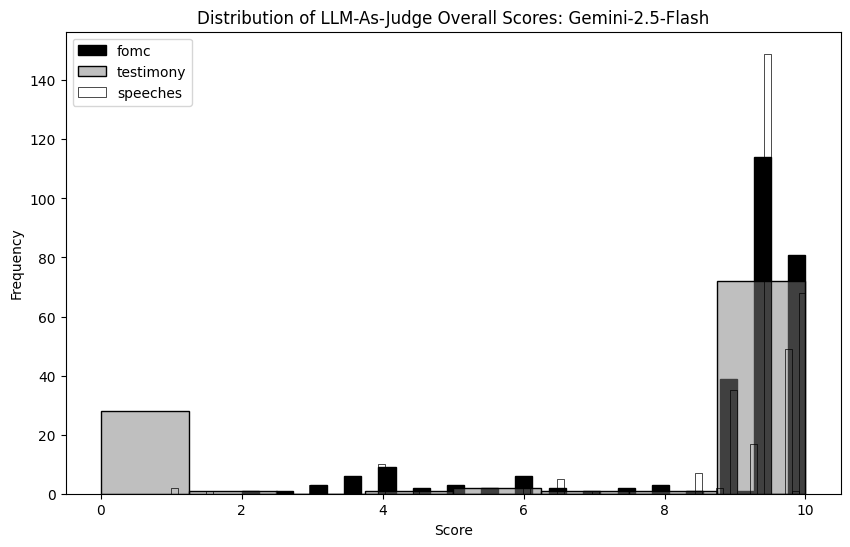

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt


doc_types = folders
df1 = all_doctype_df[doc_types[0]]['overall_score']
df2 = all_doctype_df[doc_types[1]]['overall_score']
df3 = all_doctype_df[doc_types[2]]['overall_score']
plt.figure(figsize=(10, 6))
sns.histplot(df1, kde=False, label=doc_types[0], color='black', alpha=1, multiple='dodge')
sns.histplot(df2, kde=False, label=doc_types[1], color='gray', alpha=0.5, multiple='dodge')
sns.histplot(df3, kde=False, label=doc_types[2], color='green', alpha=0, multiple='dodge')
plt.title('Distribution of LLM-As-Judge Overall Scores: Gemini-2.5-Flash')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.savefig(f'{output_path}/images/overall_score.png')
plt.show()

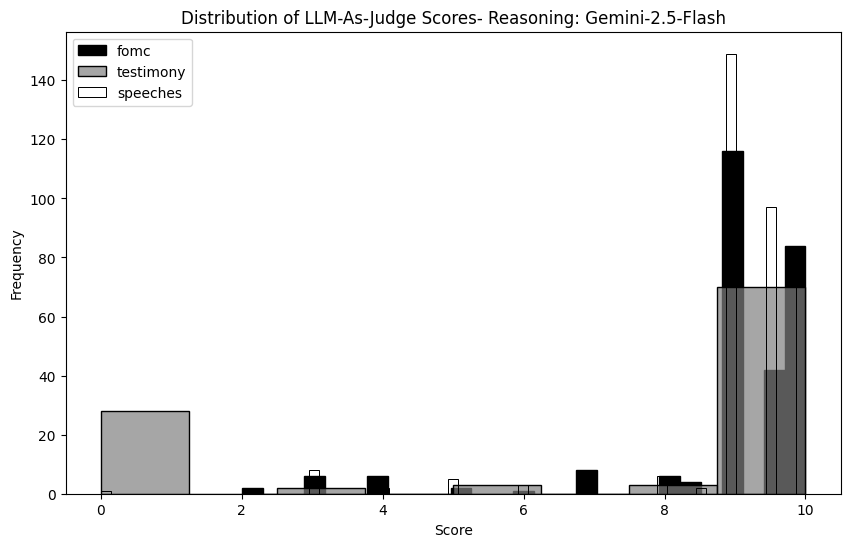

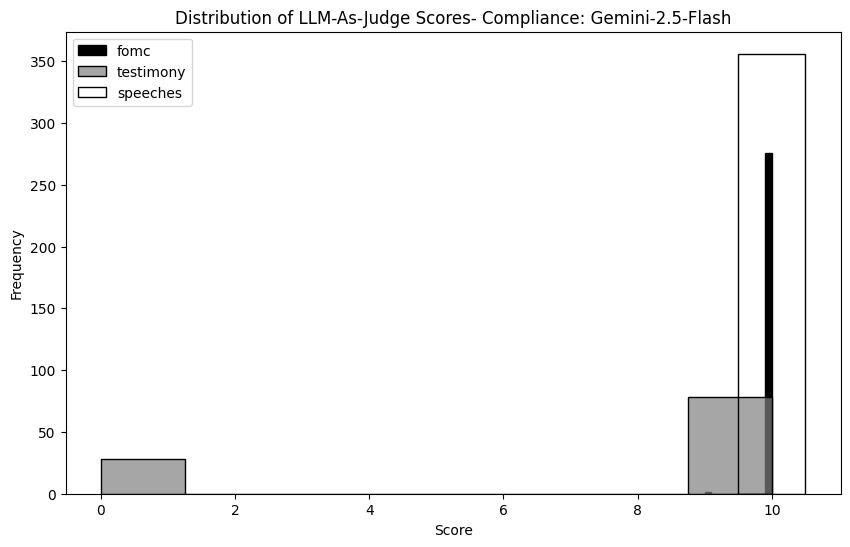

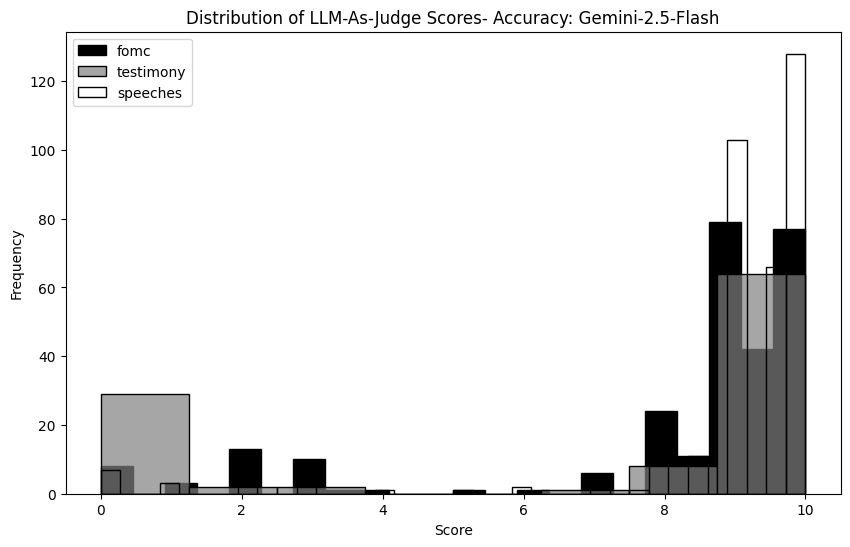

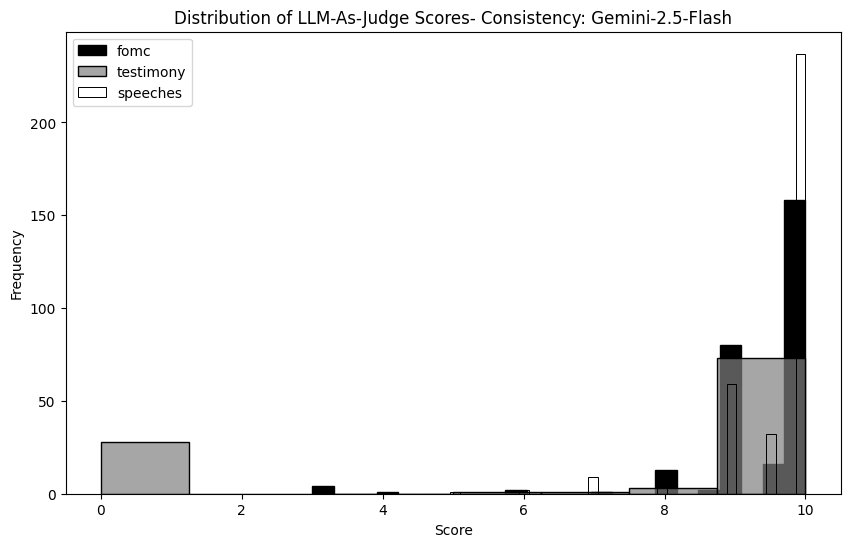

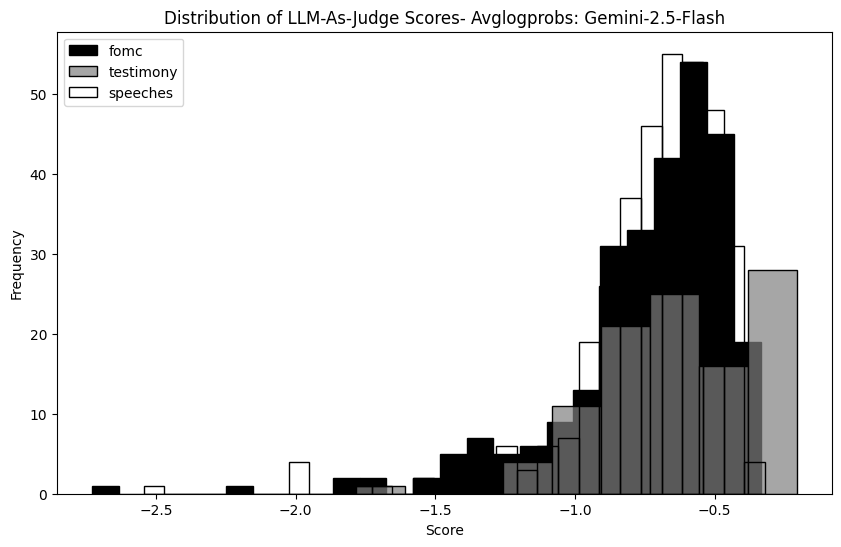

In [ ]:

score_types = 'reasoning,compliance,accuracy,consistency,avgLogprobs'.split(',')

os.makedirs(f'{output_path}/images', exist_ok=True)

for i, score_type in enumerate(score_types):

    df1 = all_doctype_df[doc_types[0]][score_type]
    df2 = all_doctype_df[doc_types[1]][score_type]
    df3 = all_doctype_df[doc_types[2]][score_type]

    plt.figure(figsize=(10, 6))

    sns.histplot(df1, kde=False, label=doc_types[0], color='black', alpha=1 ,multiple='dodge' )
    sns.histplot(df2, kde=False, label=doc_types[1], color='gray', alpha=0.7 , multiple='dodge')
    sns.histplot(df3, kde=False, label=doc_types[2], color='green', alpha=0.0,multiple='dodge')
    plt.title(f'Distribution of LLM-As-Judge Scores- {score_type.capitalize()}: Gemini-2.5-Flash' )
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(f'{output_path}/images/{score_type}.png')
    plt.show()